In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import trxtools as tt
import os
from pyCRAC.Parsers import GTF2
import pyBigWig
import numpy as np

pathTAB = "../seq_references/Saccharomyces_cerevisiae.EF4.74.dna.toplevel.shortChrNames.tab"
pathGTF = "../seq_references/Saccharomyces_cerevisiae.EF4.74.shortChNames_with_PolIII_transcripts_extended_slop_intergenic_sort.gtf"
gtf = GTF2.Parse_GTF()
gtf.read_GTF(pathGTF)
gtf.read_TAB(pathTAB)

sequences = pd.read_csv(pathTAB, sep='\t',names=['chr','sequence'],index_col=0)
chr_len = sequences['sequence'].str.len()

pathDir = "../04_BigWig/"

In [2]:
data_files_raw = [f for f in os.listdir(pathDir) if 'raw' in f and "bw" in f]
data_files_5end = [f for f in os.listdir(pathDir) if 'PROFILE_5end' in f and "bw" in f]
data_files_3end = [f for f in os.listdir(pathDir) if 'PROFILE_3end' in f and "polyA" not in f and "bw" in f]
data_files_polyA = [f for f in os.listdir(pathDir) if 'PROFILE_3end' in f and "polyA" in f and "bw" in f]

print(len(os.listdir(pathDir)))
print(len(data_files_raw))
print(len(data_files_5end))
print(len(data_files_3end))
print(len(data_files_polyA))

560
112
112
112
112


In [3]:
print(gtf.strand("RDN37-1"), gtf.chromosome("RDN37-1"), gtf.chromosomeCoordinates("RDN37-1"))
print(gtf.strand("RDN37-2"), gtf.chromosome("RDN37-2"), gtf.chromosomeCoordinates("RDN37-2"))

- chrXII (451785, 457732)
- chrXII (460922, 466869)


In [4]:
def strip_BigWig_names(files=list()):
    #returns uniq names for *fwd.bw and *rev.bw files
    return list(set([f.replace("_fwd.bw","").replace("_rev.bw","") for f in files]))

def getSeqData(gene_name, data_path, name, gtf, ranges=0):
    strand, chromosome, coordinates = gtf.strand(gene_name), gtf.chromosome(gene_name), gtf.chromosomeCoordinates(gene_name)
    if strand == "+":
        bw = pyBigWig.open(data_path+name+"_fwd.bw")
        return pd.Series(bw.values(chromosome,min(coordinates)-ranges,max(coordinates)+ranges))
    if strand == "-":
        bw = pyBigWig.open(data_path+name+"_rev.bw")
        return pd.Series(bw.values(chromosome,min(coordinates)-ranges,max(coordinates)+ranges)[::-1])

def geneFromBigWig(gene_name, data_path, data_files, gtf, ranges=0):
    df_t1 = pd.DataFrame()
    df_t1["nucleotide"] = "_".join(gtf.genomicSequence(gene_name,ranges=ranges)).split("_")
    for name in strip_BigWig_names(data_files):
        df_t1[name] = getSeqData(gene_name, data_path, name, gtf, ranges=ranges)
    return df_t1

df01_RDN37_datasets_3end = geneFromBigWig(gene_name="RDN37-1", data_path=pathDir, data_files=data_files_3end, gtf=gtf,ranges=300)
# df01_RDN37_datasets_3end.fillna(0.0).plot()

In [5]:
def getTotalCountBigWig(chrom={},data_path="", data_files=""):
    df_output = pd.DataFrame(index=chrom.keys())
    for name in strip_BigWig_names(data_files):
        df_temp = pd.DataFrame(index=chrom.keys())
        try:
            bw = pyBigWig.open(data_path+name+"_fwd.bw")
            for c in chrom.keys():
                df_temp.loc[c,'fwd']= bw.stats(c,type='sum',exact=True)[0]
        except:
            df_temp.loc[c,'fwd']= 0.0
        try:
            bw = pyBigWig.open(data_path+name+"_rev.bw")
            for c in chrom.keys():
                df_temp.loc[c,'rev']= bw.stats(c,type='sum',exact=True)[0]
        except:
            df_temp.loc[c,'rev']= 0.0
        
        df_temp = df_temp.fillna(0.0)
        df_output[name.replace("_polyA","").replace("_PROFILE_3end","").replace("_3end","").replace("_default","").replace("noUV_none","noUV")] = df_temp.sum(1)
    return df_output

df01_3ends = getTotalCountBigWig(chrom=chr_len.sort_index().to_dict(),data_path=pathDir,data_files=data_files_3end)
df02_polyA = getTotalCountBigWig(chrom=chr_len.sort_index().to_dict(),data_path=pathDir,data_files=data_files_polyA)

In [6]:
def clusterDatasets(df, name="expID_bait_background_condition_replicate"):
    out_df = df.columns.to_series().str.split("_",expand=True)
    out_df.columns = [i for i in name.split("_")] #parse names
    out_df['dataset'] = out_df['bait']+"_"+out_df['background']+"_"+out_df['condition']
    out_df['bait_background'] = out_df['bait']+"_"+out_df['background']
    return out_df

rule = {'RNAPI' : (["Rpa135HTP","Rpa190HTP"],["Rpa12dC"]),
        'Rpa12dC' : (['FPHRpa12'],["Rpa135HTP","Rpa190HTP","Rpa12dC"]),
        'RNAPI-Rpa12dC' : (["Rpa135HTP","Rpa190HTP","Rpa12dC"],['wt']),
        'RNAPII' : (["Rpo21HTP"],[]),
        'RNAPIII' : (["Rpc160HTP"],[]),
        'Rat1' : (["Rat1HTP"],[]),
        'surveillance' : (["Csl4HTP","Mtr4HTP","Rrp41HTP","Rrp44-exo-S1-HTP","Rrp44-exoHTP","Rrp44HTP","Rrp6HTP"],[]),
        "Nab2" : (["Nab2HTP"],[])
       }

def metaDatasets(name,rule={}):
    out = []
    for k in rule.keys():
        let_in = rule[k][0]
        if rule[k][1]: let_out = rule[k][1]
        else: let_out = ['Wont find this string']
                    
        if any(i for i in let_in if i in name) and any(i for i in let_out if i not in name):
            out.append(k)
    if len(out)==1:
        return out[0]
    else:
        return 'unassigned'

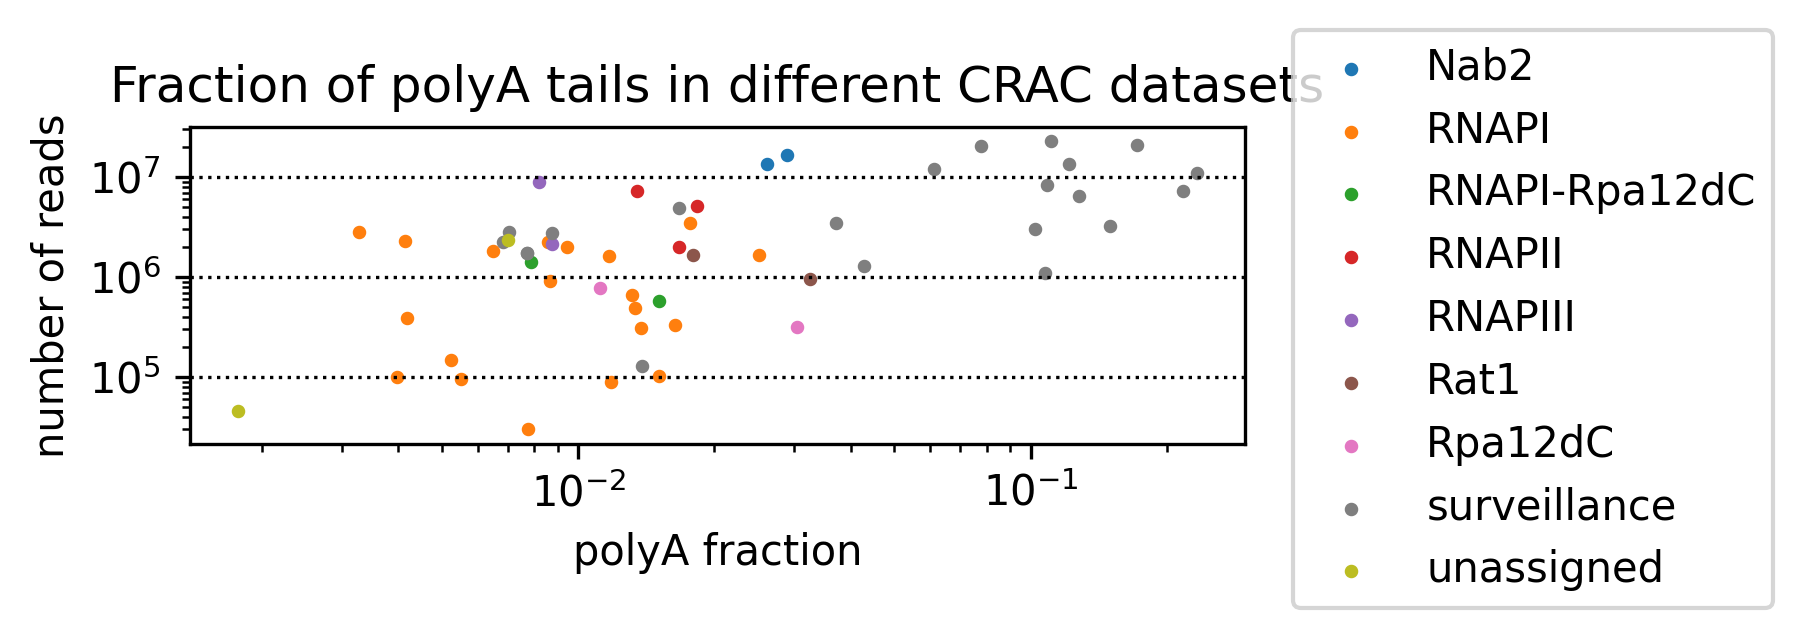

In [17]:
df03_ratio = df02_polyA.sum() / df01_3ends.sum()
df03_ratio = df03_ratio.to_frame().T
# df03_ratio.sum().sort_values()

fig, ax1 = plt.subplots(figsize=(6,2), dpi=300)
plt.title('Fraction of polyA tails in different CRAC datasets')
ax1.set_xlabel('polyA fraction')
ax1.set_ylabel('number of reads')
#     ax1.set_ylim(ylim)
clusters = clusterDatasets(df03_ratio)
clusters['meta'] = clusters['dataset'].apply(metaDatasets,rule=rule)

for n,df in clusters.groupby('meta'):
    datasets = df.index.to_list()
    x = df03_ratio[datasets].sum()
    y = df01_3ends[datasets].sum()
    ax1.scatter(x,y,s=5,alpha=1,label=n, cmap="paired")
    
ax1.grid(axis='y', c='black', ls="dotted")

# texts = []
# for x, y, s in zip(df03_ratio.sum(), df01_3ends.sum(), clusters['dataset'].tolist()):
#     plt.text(x,y,s)

plt.yscale('log')
plt.xscale('log')
# plt.xlim(0.01,10)
fig.legend(loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.7)
plt.show()

/tmp/ipykernel_24514/3300916932.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  fraction = clusters.groupby('dataset').mean()['ratio']
/tmp/ipykernel_24514/3300916932.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sd = clusters.groupby('dataset').std()['ratio']


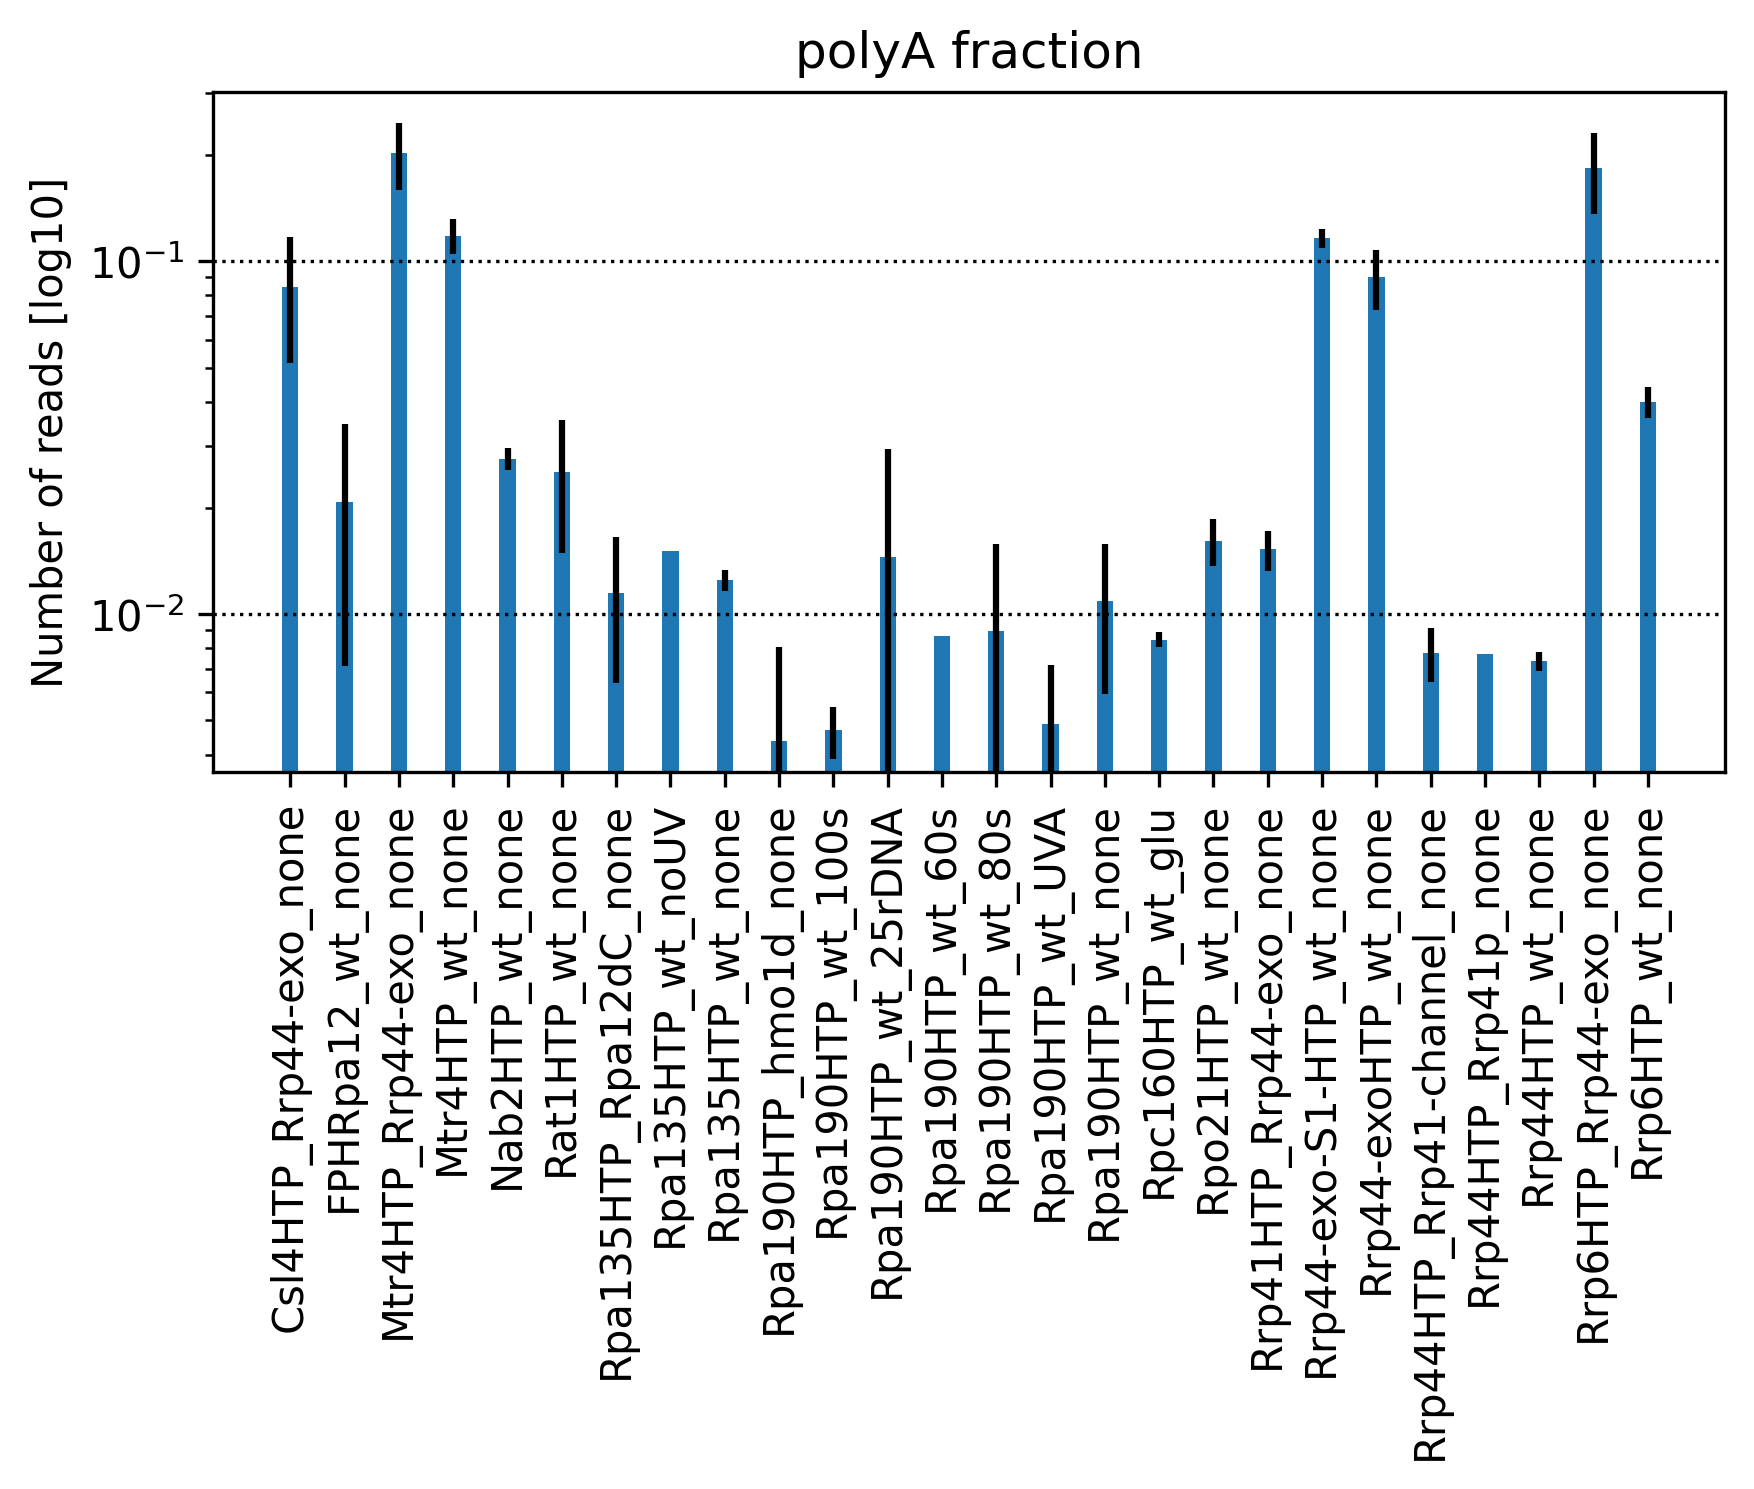

In [33]:
clusters['ratio'] = df03_ratio.T[0]

fraction = clusters.groupby('dataset').mean()['ratio']
labels = fraction.index.to_list()
sd = clusters.groupby('dataset').std()['ratio']
x = np.arange(len(fraction))
width = 0.3

fig, ax1 = plt.subplots(figsize=(len(x) / 4, 3), dpi=300)
plt.title('polyA fraction')
ax1.bar(x , fraction, width, yerr=sd)
ax1.set_yscale('log')
ax1.set_ylabel('Number of reads [log10]')
ax1.grid(axis='y', c='black', ls="dotted")
plt.xticks(x, labels, rotation=90)
plt.show()

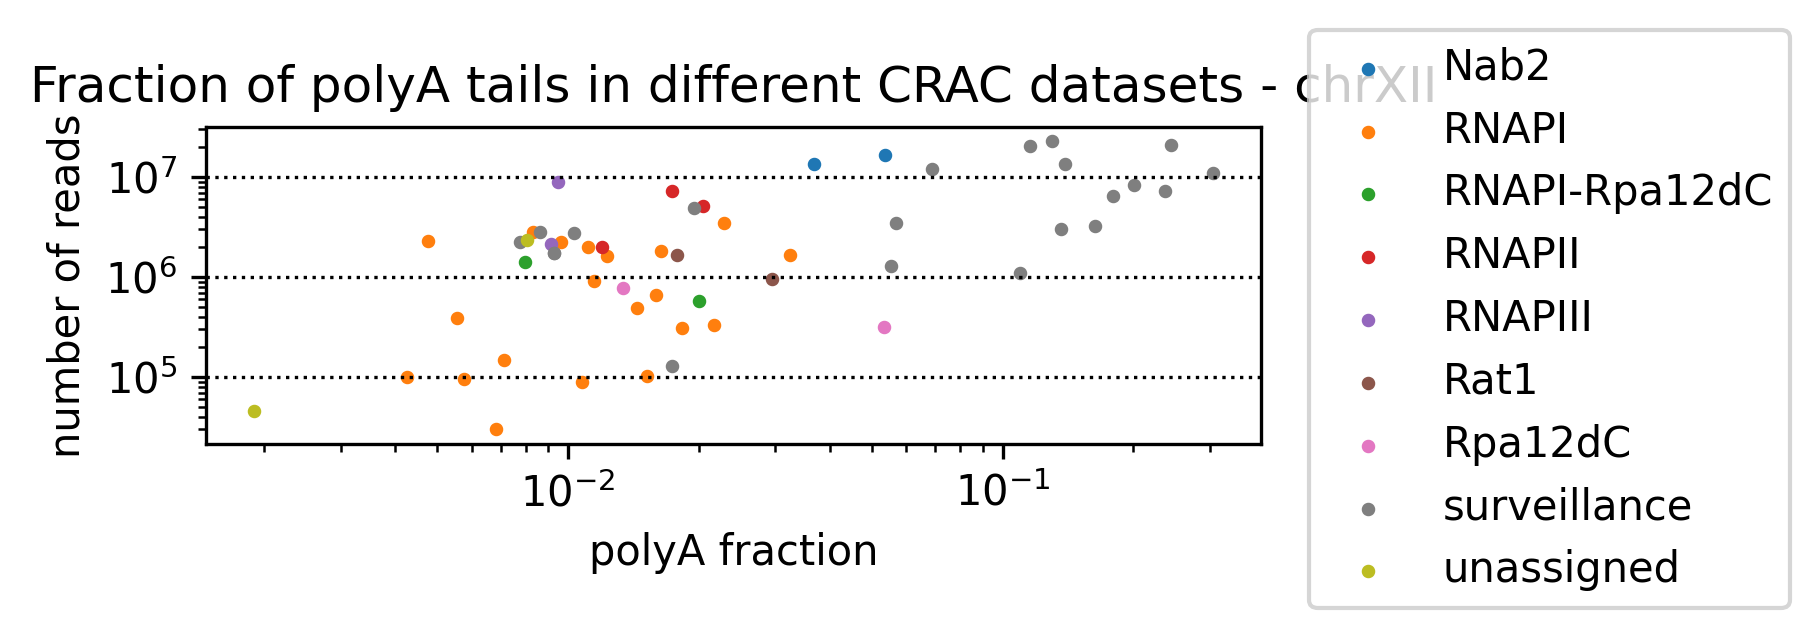

In [35]:
df04_ratio_chr12 = df02_polyA.loc['chrXII'] / df01_3ends.loc['chrXII']
df04_ratio_chr12 = df04_ratio_chr12.to_frame().T
# df03_ratio.sum().sort_values()

fig, ax1 = plt.subplots(figsize=(6,2), dpi=300)
plt.title('Fraction of polyA tails in different CRAC datasets - chrXII')
ax1.set_xlabel('polyA fraction')
ax1.set_ylabel('number of reads')
#     ax1.set_ylim(ylim)
clusters = clusterDatasets(df04_ratio_chr12)
clusters['meta'] = clusters['dataset'].apply(metaDatasets,rule=rule)

for n,df in clusters.groupby('meta'):
    datasets = df.index.to_list()
    x = df04_ratio_chr12[datasets].sum()
    y = df01_3ends[datasets].sum()
    ax1.scatter(x,y,s=5,alpha=1,label=n, cmap="paired")
    
ax1.grid(axis='y', c='black', ls="dotted")

# texts = []
# for x, y, s in zip(df03_ratio.sum(), df01_3ends.sum(), clusters['dataset'].tolist()):
#     plt.text(x,y,s)

plt.yscale('log')
plt.xscale('log')
# plt.xlim(0.01,10)
fig.legend(loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.7)
plt.show()

/tmp/ipykernel_24514/510497532.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  fraction = clusters.groupby('dataset').mean()['ratio']
/tmp/ipykernel_24514/510497532.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sd = clusters.groupby('dataset').std()['ratio']


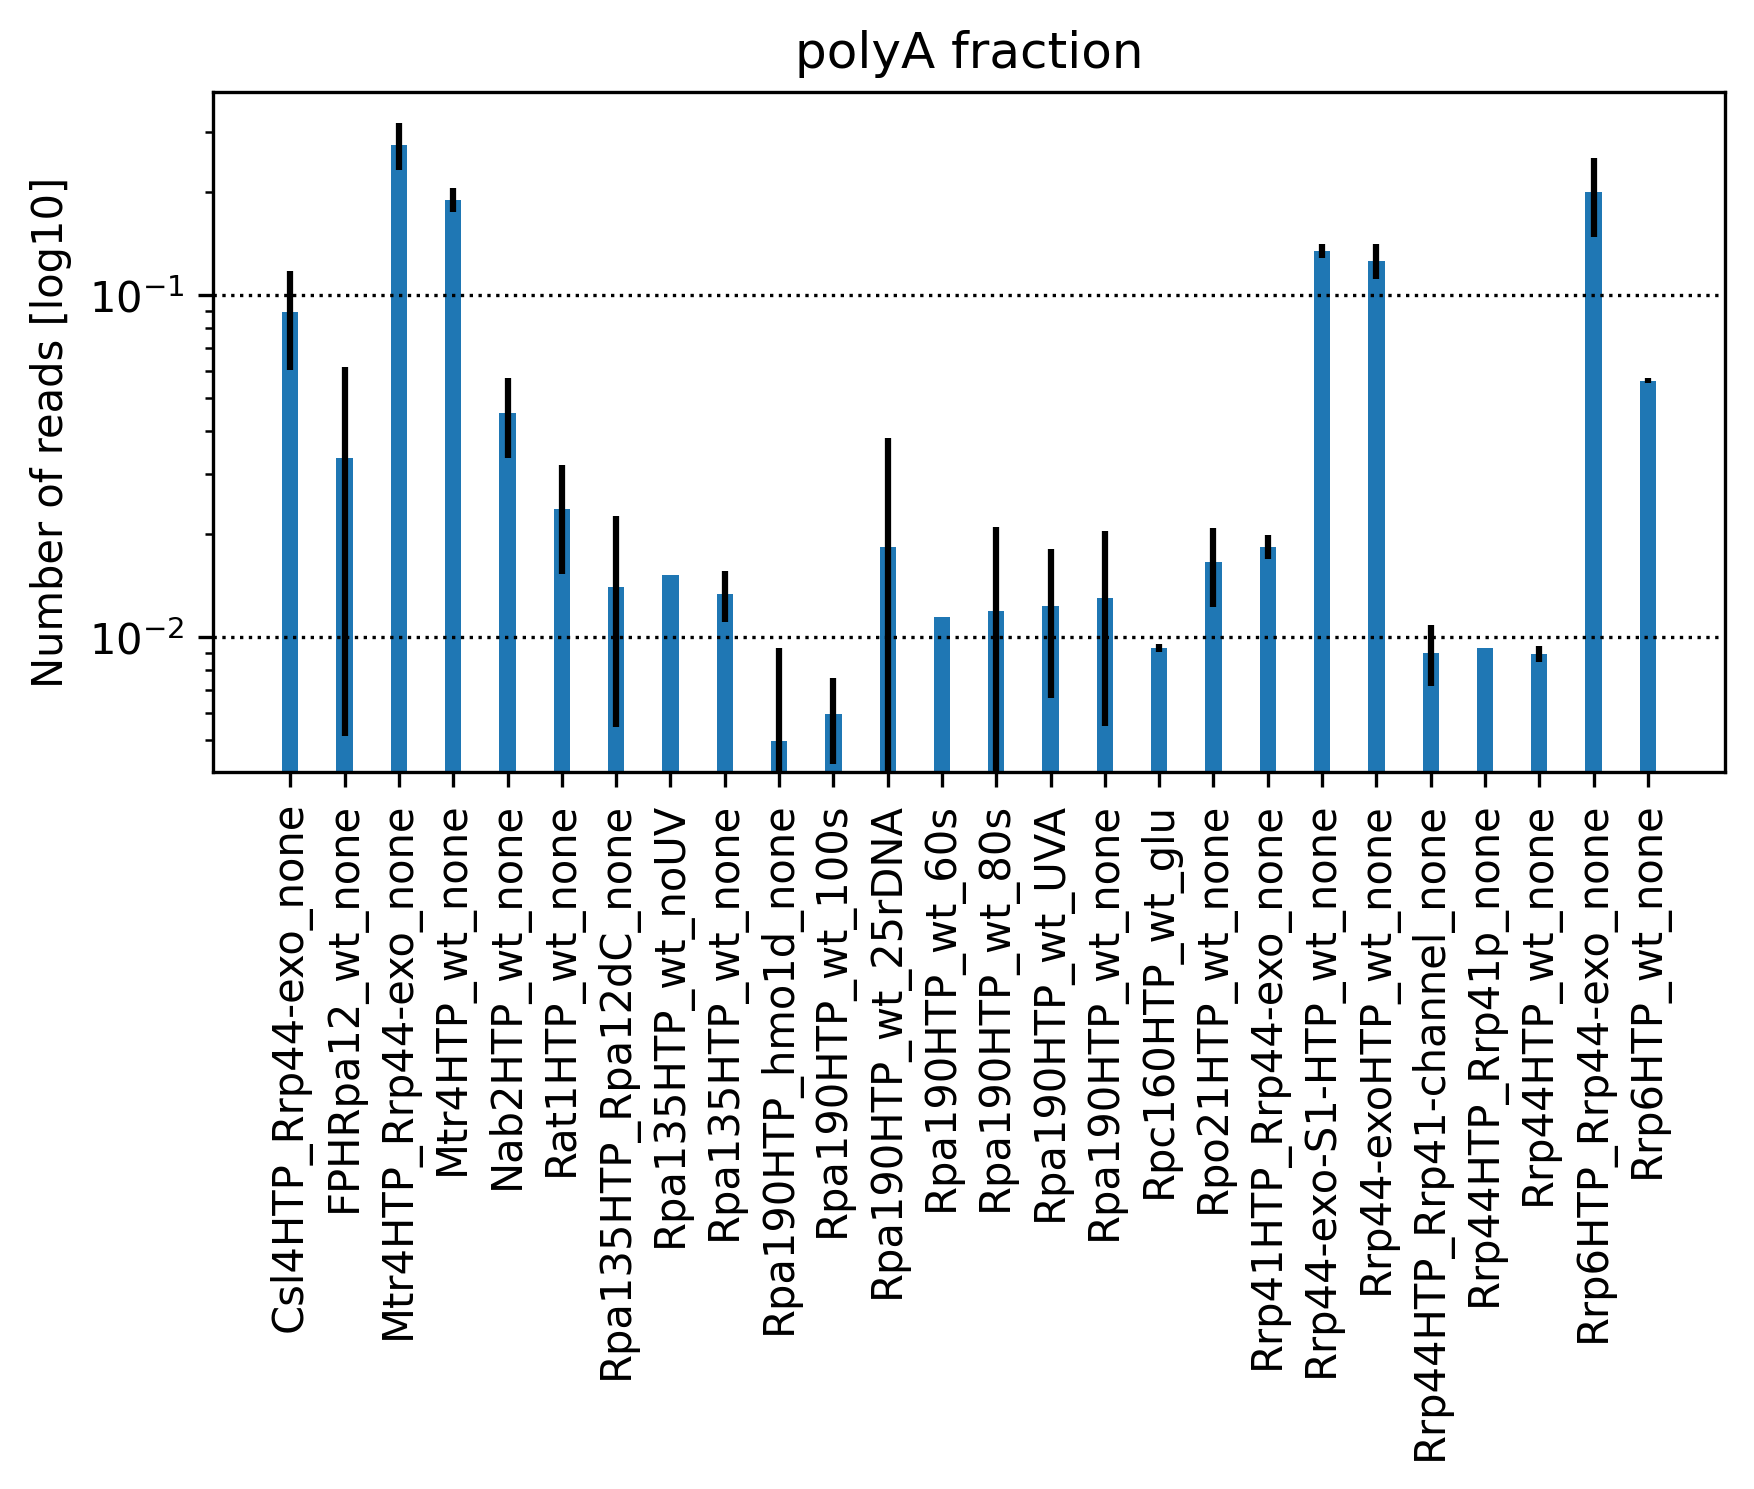

In [37]:
clusters['ratio'] = df04_ratio_chr12.T

fraction = clusters.groupby('dataset').mean()['ratio']
labels = fraction.index.to_list()
sd = clusters.groupby('dataset').std()['ratio']
x = np.arange(len(fraction))
width = 0.3

fig, ax1 = plt.subplots(figsize=(len(x) / 4, 3), dpi=300)
plt.title('polyA fraction')
ax1.bar(x , fraction, width, yerr=sd)
ax1.set_yscale('log')
ax1.set_ylabel('Number of reads [log10]')
ax1.grid(axis='y', c='black', ls="dotted")
plt.xticks(x, labels, rotation=90)
plt.show()